In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from cana.drawing.canalizing_map import draw_canalizing_map_graphviz
from cana.boolean_network import BooleanNetwork 

In [34]:
# testBN = BooleanNetwork.from_file(r"C:\Users\aksha\CANA\test-BN.txt", keep_constants=True)
testBN = BooleanNetwork.from_file("./test-BN.txt", keep_constants=True)

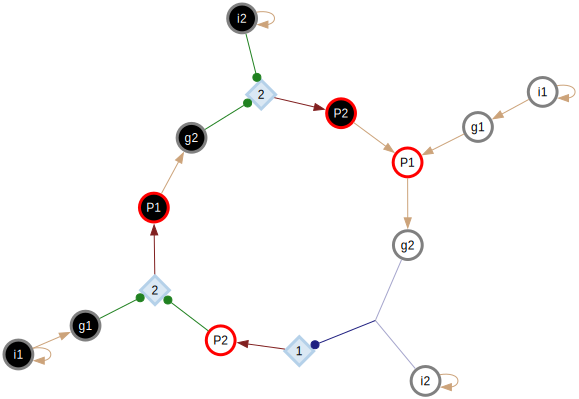

In [35]:
# Request the DCM to the Network
DCM = testBN.dynamics_canalization_map(simplify=True)
# Draws using the graphviz interface.
gDCM = draw_canalizing_map_graphviz(DCM)
# Display
display(gDCM)

***Plot lookup table of the BN***

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.text import Text
from matplotlib.patches import Circle, Rectangle, RegularPolygon
from matplotlib.collections import PatchCollection

def plot_look_up_table(n):
    # Init values from BooleanNode
    k = n.k if n.k>=1 else 1
    inputs = n.inputs if not n.constant else [n.name]
    inputlabels = [n.network.get_node_name(i)[0] if n.network is not None else i for i in inputs]
    LUT = n.look_up_table().sort_index(ascending=False)
    # Count number of F in the LUT
    n_fs = LUT.shape[0]
    # Schemata Cell Width and spacing
    cwidth = 60.
    cxspace = 0
    cyspace = 6
    border = 1
    sepcxspace = 21
    sepcyspace = 15
    dpi = 150.
    # Margins
    top, right, bottom, left, hs = 120, 25, 25, 60, 25
    # Axes Width & Height
    ax1width = ((k*(cwidth+cxspace))+sepcxspace+(cwidth))
    ax1height = (n_fs*(cwidth+cyspace)-cyspace)
    # Figure Width & Height
    fwidth = (left + ax1width + hs + right)
    fheight = (bottom + ax1height + top)
    # Percentages for Axes location
    _ax1w = ((ax1width*100) / fwidth) / 100
    _ax1h = ((ax1height*100) / fheight) / 100
    _bottom = ((bottom*100) / fheight) / 100
    _left = ((left*100) / fwidth) / 100
    _hs = ((hs*100) / fwidth) / 100
    # Init Figure
    fig = plt.figure(figsize=(fwidth/dpi,fheight/dpi), facecolor='w', dpi=dpi)
    ax1 = fig.add_axes((_left,_bottom,_ax1w,_ax1h), aspect=1, label='LUT')

    ### LUT Plot ###

    yticks = []
    patches = []
    x,y = 0.,0.
    #
    for i,r in LUT.iterrows():
        ins = str(r['In:'])
        out = r['Out:']
        x = 0.
        xticks = []
        for input in ins:
            if input == '0':
                facecolor = 'white'
                textcolor = 'black'
            elif input == '1':
                facecolor = 'black'
                textcolor = 'white'      
            text = '{label:s}'.format(label=input)
            ax1.add_artist(Text(x+cwidth/2,y+cwidth/10*4, text=text, color=textcolor, va='center', ha='center',fontsize=14,family='serif'))
            r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor=facecolor, edgecolor='black')
            patches.append(r)
            xticks.append(x+cwidth/2)
            x += cwidth + cxspace

        x += sepcxspace
        r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor='black' if (out==1) else 'white', edgecolor='black')
        ax1.add_artist(Text(x-(sepcxspace/2)-(cxspace/2),y+cwidth/10*4, text=':', color='black', va='center', ha='center',fontsize=14,weight='bold',family='serif'))
        ax1.add_artist(Text(x+(cwidth/2),y+cwidth/10*4, text=out, color='white' if (out==1) else 'black', va='center', ha='center',fontsize=14,family='serif'))
        patches.append(r)
        xticks.append(x+cwidth/2)
        yticks.append(y+cwidth/2)
        y += cwidth + cyspace

        #y += sepcyspace

    ax1.add_collection(PatchCollection(patches, match_original=True))
    #
    ax1.set_yticks(yticks)
    ax1.set_yticklabels([r"$f_{%d}$"%(i+1) for i in range(n_fs)[::-1]], fontsize=14)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(inputlabels + ['%s'%(n.name)], rotation=90, fontsize=14)
    #
    ax1.xaxis.tick_top()
    # Remove Tick
    ax1.tick_params(which='major',pad=7)
    for tic in ax1.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in ax1.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    # Remove Border
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    # Limits
    ax1.set_xlim(-border,ax1width+border)
    ax1.set_ylim(-border,ax1height+border)
    #ax1.invert_yaxis() 

    # FileName
    filename = n.name
    filename = filename.replace('/','_')
    filename = filename.replace(',','_')
    
    ## Display
    display(fig)
    
    plt.close()

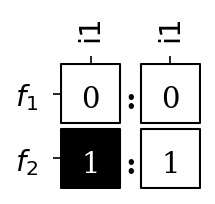

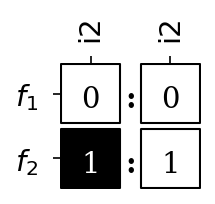

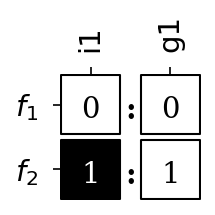

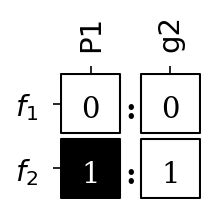

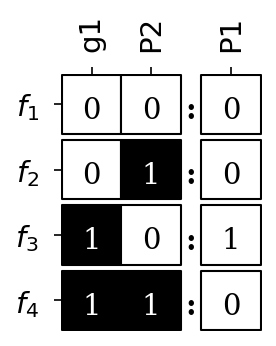

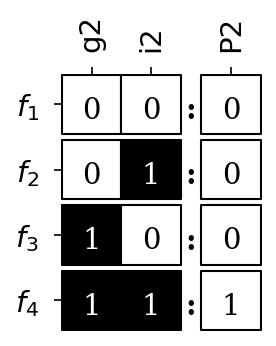

In [12]:
for i in range(len(testBN.nodes)):
    plot_look_up_table(testBN.nodes[i])
    #plot_look_up_table(testBN.nodes[i], filename=filename)
    #plt.savefig(os.path.join('LUTs', filename+'.png'), dpi=150, bbox_inches='tight')
    #plt.close()

***Plot Prime Implicants (F') and Two-Symbol (F'') Schematas***

In [13]:
from copy import copy

def plot_schemata(n):
    # Init values from BooleanNode
    k = n.k if n.k>=1 else 1
    inputs = n.inputs if not n.constant else [n.name]
    inputlabels = [n.network.get_node_name(i)[0] if n.network is not None else i for i in inputs]
    pi0s = n._prime_implicants.get('0', [])
    pi1s = n._prime_implicants.get('1', [])
    ts0s = n._two_symbols[0]
    ts1s = n._two_symbols[1]
    # Count number of PI and TS
    n_pi = sum(len(pis) for pis in [pi0s,pi1s])
    n_ts = sum(len(tss) for tss in [ts0s,ts1s])
    # Schemata Cell Width and spacing
    cwidth = 60.
    cxspace = 0
    cyspace = 6
    border = 1
    sepcxspace = 21
    sepcyspace = 15
    dpi = 150.
    # Margins
    top, right, bottom, left, hs = 160, 25, 25, 60, 60
    # Axes Width & Height
    ax1width = ((k*(cwidth+cxspace))+sepcxspace+(cwidth))
    ax1height = (n_pi*(cwidth+cyspace)+sepcyspace-cyspace)
    ax2width = ((k*(cwidth+cxspace))+sepcxspace+(cwidth))
    ax2height = (n_ts*(cwidth+cyspace)+sepcyspace-cyspace)
    # Figure Width & Height
    fwidth = (left + ax1width + hs + ax2width + right)
    fheight = (bottom + max(ax1height,ax2height) + top)
    # Percentages for Axes location
    _ax1w = ((ax1width*100) / fwidth) / 100
    _ax2w = ((ax2width*100) / fwidth) / 100
    _ax1h = ((ax1height*100) / fheight) / 100
    _ax2h = ((ax2height*100) / fheight) / 100
    _bottom = ((bottom*100) / fheight) / 100
    _left = ((left*100) / fwidth) / 100
    _hs = ((hs*100) / fwidth) / 100
    # Init Figure
    fig = plt.figure(figsize=(fwidth/dpi,fheight/dpi), facecolor='w', dpi=dpi)
    ax1 = fig.add_axes((_left,_bottom,_ax1w,_ax1h), aspect=1, label='PI')
    ax2 = fig.add_axes((_left+_ax1w+_hs,_bottom,_ax2w,_ax1h), aspect=1, label='TS')

    ### PI Plot ###

    yticks = []
    patches = []
    x,y = 0.,0.
    #
    for out,pis in zip([1,0],[pi1s,pi0s]):
        for pi in pis:
            x = 0.
            xticks = []
            for input in pi:
                if input == '0':
                    facecolor = 'white'
                    textcolor = 'black'
                elif input == '1':
                    facecolor = 'black'
                    textcolor = 'white'
                elif input == '#':
                    facecolor = '#cccccc'
                    textcolor = 'black'            
                text = '%s'%(input) if (input!='2') else '#'
                ax1.add_artist(Text(x+cwidth/2,y+cwidth/10*4, text=text, color=textcolor, va='center', ha='center',fontsize=14,family='serif'))
                r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor=facecolor, edgecolor='black')
                patches.append(r)
                xticks.append(x+cwidth/2)
                x += cwidth + cxspace

            x += sepcxspace
            r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor='black' if (out==1) else 'white', edgecolor='black')
            ax1.add_artist(Text(x-(sepcxspace/2)-(cxspace/2),y+cwidth/10*4, text=':', color='black', va='center', ha='center',fontsize=14,weight='bold',family='serif'))
            ax1.add_artist(Text(x+(cwidth/2),y+cwidth/10*4, text=out, color='white' if (out==1) else 'black', va='center', ha='center',fontsize=14,family='serif'))
            patches.append(r)
            xticks.append(x+cwidth/2)
            yticks.append(y+cwidth/2)
            y += cwidth + cyspace
        y += sepcyspace

    ax1.add_collection(PatchCollection(patches,match_original=True))
    #
    ax1.set_yticks(yticks)
    ax1.set_yticklabels([r"$f^{'}_{%d}$"%(i+1) for i in range(n_pi)[::-1]], fontsize=14)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(inputlabels + ['%s'%(n.name)], rotation=90, fontsize=14)
    #
    ax1.xaxis.tick_top()
    # Remove Tick
    ax1.tick_params(which='major',pad=7)
    for tic in ax1.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in ax1.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    # Remove Border
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    # Limits
    ax1.set_xlim(-border,ax1width+border)
    ax1.set_ylim(-border,ax1height+border)
    #ax1.invert_yaxis() 

    ## TS ##

    t = 0
    x,y = 0.,0.
    yticks = []
    boxes,symbols = [], []
    #
    tssymbols = [
        Circle((0, 0), radius=5, facecolor='white', edgecolor='black'),
        RegularPolygon((0, 0),numVertices=3, radius=5, orientation=0, facecolor='white', edgecolor='black'),
    ]
    #
    for out,tss in zip([1,0],[ts1s,ts0s]):
        for ts,pss,sss in tss:
            x = 0.
            xticks = []
            for i,input in enumerate(ts):
                if input == '0':
                    facecolor = 'white'
                    textcolor = 'black'
                elif input == '1':
                    facecolor = 'black'
                    textcolor = 'white'
                elif input == '2':
                    facecolor = '#cccccc'
                    textcolor = 'black'

                if len(pss):
                    # TODO: If there are several symbols in the same input position, place them side-by-side
                    iinpss = [j for j,ps in enumerate(pss) if i in ps]
                    xpos = np.linspace(x,x+cwidth, len(iinpss)+2)
                    for z,j in enumerate(iinpss,start=1):
                        s = copy(tssymbols[j])
                        s.xy = (xpos[z],y+cwidth*0.8)
                        s.center = xpos[z],y+cwidth*0.8 # A hack for circles only
                        s.set_edgecolor('#a6a6a6' if (input=='1') else 'black')
                        symbols.append(s)
                        ax2.add_patch(s)

                text = '%s'%(input) if (input!='2') else '#'
                ax2.add_artist(Text(x+cwidth/2,y+cwidth/10*4, text=text, color=textcolor, va='center', ha='center',fontsize=14,family='serif'))
                r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor=facecolor, edgecolor='#4c4c4c',zorder=2)
                boxes.append(r)
                xticks.append(x+cwidth/2)
                x += cwidth + cxspace

            x += sepcxspace
            r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor='black' if (out==1) else 'white', edgecolor='#4c4c4c')
            ax2.add_artist(Text(x-(sepcxspace/2)-(cxspace/2),y+cwidth/2, text=':', color='black', va='center', ha='center',fontsize=14,weight='bold',family='serif'))
            ax2.add_artist(Text(x+(cwidth/2),y+cwidth/10*4, text=out, color='white' if (out==1) else 'black', va='center', ha='center',fontsize=14,family='serif'))
            boxes.append(r)
            xticks.append(x+cwidth/2)
            yticks.append(y+cwidth/2)
            y += cwidth + cyspace
            t += 1
        y += sepcyspace

    if len(boxes):
        ax2.add_collection(PatchCollection(boxes,match_original=True))
    if len(symbols):
        ax2.add_collection(PatchCollection(symbols,match_original=True))
    #
    ax2.set_yticks(yticks)
    ax2.set_yticklabels([r"$f^{''}_{%d}$"%(i+1) for i in range(n_ts)[::-1]], fontsize=14)
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(inputlabels + ['%s'%(n.name)], rotation=90, fontsize=14)
    #
    ax2.xaxis.tick_top()
    # Remove Tick
    ax2.tick_params(which='major',pad=7)
    for tic in ax2.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in ax2.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    # Remove Border
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    # Limits
    ax2.set_xlim(-border,ax2width+border)
    ax2.set_ylim(-border,ax2height+border)

    # FileName
    filename = n.name.replace('/','_')
    filename = filename.replace(',','_')
    
    ## Display ##
    display(fig)
    
    plt.close()

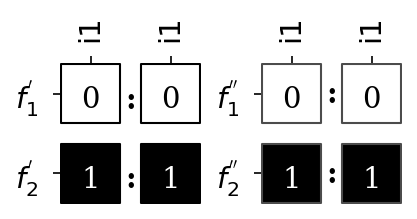

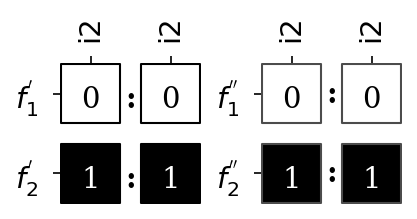

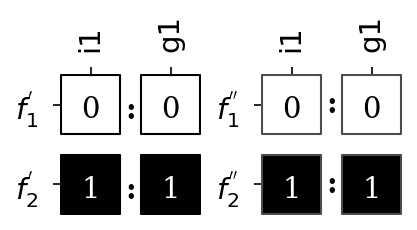

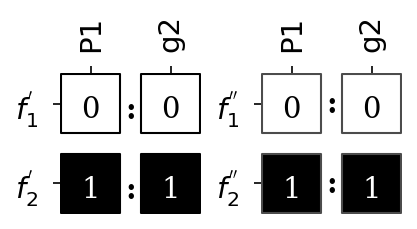

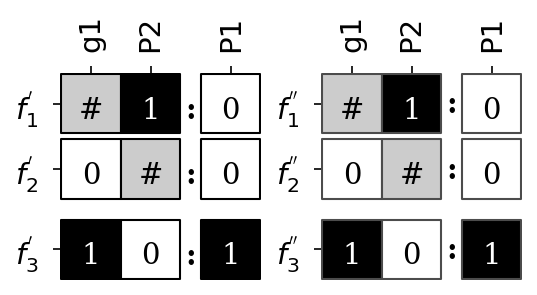

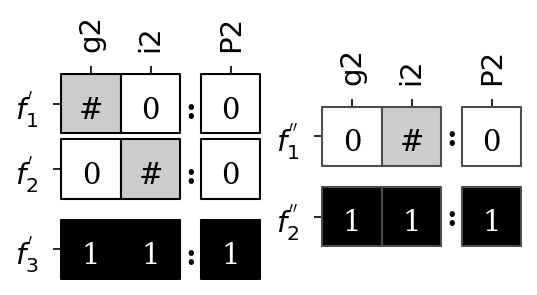

In [20]:
for node in testBN.nodes:
    node._check_compute_canalization_variables(prime_implicants=True)
    node._check_compute_canalization_variables(two_symbols=True)
    # print(node.name)
    plot_schemata(node)

In [16]:
t = testBN.nodes[4]
print(t.name)

P1


***Draw the State Transition Graph***

In [21]:
import networkx as nx
import graphviz
import cana

In [36]:
STG = testBN.state_transition_graph()
print(STG.nodes(data=True))
attractors = testBN.attractors(mode='stg')
print('STG: %s' % (attractors))

[(0, {'label': '000000'}), (1, {'label': '000001'}), (2, {'label': '000010'}), (3, {'label': '000011'}), (4, {'label': '000100'}), (5, {'label': '000101'}), (6, {'label': '000110'}), (7, {'label': '000111'}), (8, {'label': '001000'}), (9, {'label': '001001'}), (10, {'label': '001010'}), (11, {'label': '001011'}), (12, {'label': '001100'}), (13, {'label': '001101'}), (14, {'label': '001110'}), (15, {'label': '001111'}), (16, {'label': '010000'}), (17, {'label': '010001'}), (18, {'label': '010010'}), (19, {'label': '010011'}), (20, {'label': '010100'}), (21, {'label': '010101'}), (22, {'label': '010110'}), (23, {'label': '010111'}), (24, {'label': '011000'}), (25, {'label': '011001'}), (26, {'label': '011010'}), (27, {'label': '011011'}), (28, {'label': '011100'}), (29, {'label': '011101'}), (30, {'label': '011110'}), (31, {'label': '011111'}), (32, {'label': '100000'}), (33, {'label': '100001'}), (34, {'label': '100010'}), (35, {'label': '100011'}), (36, {'label': '100100'}), (37, {'lab

Nodes: 64 | Edges: 64


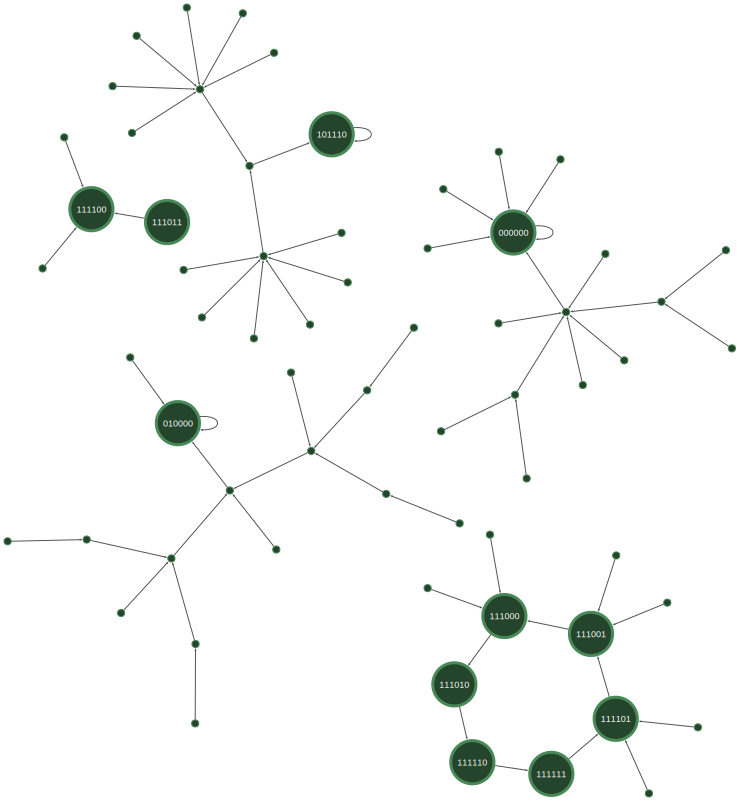

In [ ]:
# Draw the State Transition Graph
G = graphviz.Digraph(name='State Transition Graph', engine='neato')
G.attr('graph', concentrate='true', simplify='true', overlap='true')
G.attr('node', shape='circle', fixedsize='true', width='.4', color='#488957', style='filled', fillcolor='#24442b', penwidth='3', fontname='Helvetica', fontcolor='white',fontsize='9')
G.attr('edge', arrowhead='normal', arrowsize='.1', color='#545454')

for node,d in STG.nodes(data=True):
    if any(node in attractor for attractor in attractors): #node in attractors:
        label = d['label']
        width = '0.6'
        penwidth = '3'
    else:
        label = ''
        width = '0.1'
        penwidth = '1'
    G.node(name=str(node), label=label, width=width, penwidth=penwidth)
for s, t, d in STG.edges(data=True):
    G.edge(str(s),str(t))
print('Nodes: %d | Edges: %d' % (len(STG.nodes()) , len(STG.edges()) ))
display(G)


In [39]:
# save the figure
G.render(filename='STG', format='png', cleanup=True, directory='figures', engine='neato')

'figures\\STG.png'

### WHAT IS THE 'BNS' MODE? WHAT DOES IT DO? RESOLVE THIS ERROR.

In [32]:

attractors_ = testBN.attractors(mode='bns') 
print('BNS: %s' % (attractors_))

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\aksha\\AppData\\Local\\Temp\\tmprne79crw'